In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10,sqrt
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [3]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [4]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [5]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

In [6]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

In [7]:
search_term = 'irma'

In [8]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

ns_size = 1
# ---------- Skip-Gram ----------
# initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)

# train the model over 10 epochs
vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

# assign the vector data to its position in a series
# vectors_series.iloc[i] = vector_model

(1180791, 1289640)

In [9]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# # ---------- Skip-Gram ----------
# # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
# vector_model = Word2Vec(tweets_tokens, min_count=1, window=5, workers=1, size=100, seed=1, negative=1)

# # train the model over 10 epochs
# vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

In [10]:
vector_model.wv.most_similar(search_term)

/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pass', 0.7625612020492554),
 ('hit', 0.7501078844070435),
 ('move', 0.7244436740875244),
 ('eye', 0.7225500345230103),
 ('away', 0.7124370336532593),
 ('shortli', 0.7074049115180969),
 ('around', 0.6974090337753296),
 ('slightli', 0.6877397298812866),
 ('wall', 0.6838585138320923),
 ('direct', 0.6806619167327881)]

In [11]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [12]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
def ScoreTweetFromVectorsMSC(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [13]:
# func_type = "Dot Product of Tweet Vector and Search Term"
# func_short = "DotProduct"
def ScoreTweetFromVectorsDP(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [14]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [15]:
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
def ScoreTweetFromVectorsSSSCS(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [16]:
#      Scoring tweets in this column:
score_type = 'MSC'
sw = f'score_window_{score_type}'
mmsw = f'MM_{sw}'
tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectorsMSC,args=(vector_model,))

#     column of scores for this iteration
tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

score_type = 'DP'
sw = f'score_window_{score_type}'
mmsw = f'MM_{sw}'
tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectorsDP,args=(vector_model,))

#     column of scores for this iteration
tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

score_type = 'CSTVS'
sw = f'score_window_{score_type}'
mmsw = f'MM_{sw}'
tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectorsCSTVS,args=(vector_model,))

#     column of scores for this iteration
tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

score_type = 'SSSCS'
sw = f'score_window_{score_type}'
mmsw = f'MM_{sw}'
tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectorsSSSCS,args=(vector_model,))

#     column of scores for this iteration
tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [17]:
tweet_encoded

,index,irma_rel,tweet,timestamp,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,...,tweet_lang,hashtags,score_window_MSC,MM_score_window_MSC,score_window_DP,MM_score_window_DP,score_window_CSTVS,MM_score_window_CSTVS,score_window_SSSCS,MM_score_window_SSSCS
0,0,1,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",2017-09-10 00:00:01,906668545542680576,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",1227982520,"[28.87527778,-81.2525]","[[[-81.285896, 28.84511], [-81.285896, 28.9640...",-81.2525,...,en,NaN,0.213561,47.556372,24.951485,52.353162,0.280631,52.028934,0.675339,54.622923
1,1,0,There is always beauty regardless the circumst...,2017-09-10 00:00:03,906668555185291265,There is always beauty regardless the circumst...,42239064,"[29.5381,-81.2234]","[[[-81.279617, 29.424649], [-81.279617, 29.627...",-81.2234,...,en,NaN,0.399590,59.961693,13.418232,31.519142,0.576160,71.736286,1.057215,65.993432
2,2,0,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,2017-09-10 00:00:03,906668556493889536,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,87188071,"[28.4363045,-81.4797168]","[[[-87.634643, 24.396308], [-87.634643, 31.001...",-81.4797,...,en,"Carpool,Orlando,Orlando,KIrkmanRoad",0.286244,52.403207,8.719169,23.030611,0.556120,70.399916,0.858731,60.083480
3,3,0,@avictoria_x nah i m chillin my eyes never get...,2017-09-10 00:00:06,906668570079309830,@avictoria_x nah i m chillin my eyes never get...,746764728,NaN,"[[[-81.25235, 28.549308], [-81.25235, 28.58224...",-81.2380,...,en,NaN,0.414413,60.950204,9.592638,24.608472,0.638344,75.882970,1.015101,64.739476
4,4,0,@jvnvy @sza That s how I feel bout seein travis,2017-09-10 00:00:08,906668576056246278,@jvnvy @sza That s how I feel bout seein travis,1679199278,NaN,"[[[-82.31457, 27.823335], [-82.31457, 27.85374...",-82.2877,...,en,NaN,0.183312,45.539251,2.427986,11.666026,0.289165,52.598001,0.366625,45.430841
5,5,1,Taking a beak from boarding the windows. Kitty...,2017-09-10 00:00:10,906668586793660416,Taking a beak from boarding the windows. Kitty...,33160615,"[27.91,-82.35]","[[[-87.634643, 24.396308], [-87.634643, 31.001...",-82.3500,...,en,NaN,0.362175,57.466708,6.190383,18.462535,0.538408,69.218754,0.887145,60.929515
6,6,1,"19:53 Temp. 82.4 F, Hum. 79 , Dewp. 73.6 F, Ba...",2017-09-10 00:00:11,906668589385764864,"19:53 Temp. 82.4 F, Hum. 79 , Dewp. 73.6 F, Ba...",19511251,"[27.86977674,-82.80524377]","[[[-82.81611, 27.80979], [-82.81611, 27.884351...",-82.8052,...,en,NaN,0.167353,44.474972,20.358081,44.055498,0.219732,47.967913,0.579726,51.776021
7,7,1,"I m so proud of our local radio, news, animal ...",2017-09-10 00:00:11,906668590878871555,"I m so proud of our local radio, news, animal ...",328572345,NaN,"[[[-82.771167, 27.839081], [-82.771167, 27.878...",-82.7544,...,en,IrmaHurricane2017,0.418688,61.235227,21.086942,45.372134,0.584090,72.265040,1.388630,75.861421
8,8,1,Evening of a Hurricane. #hurricane #hurricanei...,2017-09-10 00:00:12,906668595358216192,Evening of a Hurricane. #hurricane #hurricanei...,278782686,"[27.9709,-82.4646]","[[[-82.620093, 27.821353], [-82.620093, 28.171...",-82.4646,...,en,"hurricane,hurricaneirma,sunset,tampa,florida,w...",0.406088,60.395006,19.631091,42.742240,0.516667,67.768957,1.218263,70.788695
9,9,0,hey big head https://t.co/M46uNJoxx2,2017-09-10 00:00:14,906668601817669632,hey big head https://t.co/M46uNJoxx2,2661138289,NaN,"[[[-80.352067, 25.923399], [-80.352067, 25.957...",-80.3226,...,en,NaN,0.515700,67.704475,5.715345,17.604412,0.601386,73.418453,0.893218,61.110357


In [18]:
test_cols = ['tweet','irma_rel','MM_score_window_MSC','MM_score_window_DP','MM_score_window_CSTVS','MM_score_window_SSSCS']

In [19]:
tweet_encoded[test_cols]

,tweet,irma_rel,MM_score_window_MSC,MM_score_window_DP,MM_score_window_CSTVS,MM_score_window_SSSCS
0,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",1,47.556372,52.353162,52.028934,54.622923
1,There is always beauty regardless the circumst...,0,59.961693,31.519142,71.736286,65.993432
2,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,0,52.403207,23.030611,70.399916,60.083480
3,@avictoria_x nah i m chillin my eyes never get...,0,60.950204,24.608472,75.882970,64.739476
4,@jvnvy @sza That s how I feel bout seein travis,0,45.539251,11.666026,52.598001,45.430841
5,Taking a beak from boarding the windows. Kitty...,1,57.466708,18.462535,69.218754,60.929515
6,"19:53 Temp. 82.4 F, Hum. 79 , Dewp. 73.6 F, Ba...",1,44.474972,44.055498,47.967913,51.776021
7,"I m so proud of our local radio, news, animal ...",1,61.235227,45.372134,72.265040,75.861421
8,Evening of a Hurricane. #hurricane #hurricanei...,1,60.395006,42.742240,67.768957,70.788695
9,hey big head https://t.co/M46uNJoxx2,0,67.704475,17.604412,73.418453,61.110357


In [20]:
for i in ['MSC','DP','CSTVS','SSSCS']:
    print(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']))

0.6904583907290875
0.8464484455966883
0.7467259177304093
0.7936167782592627


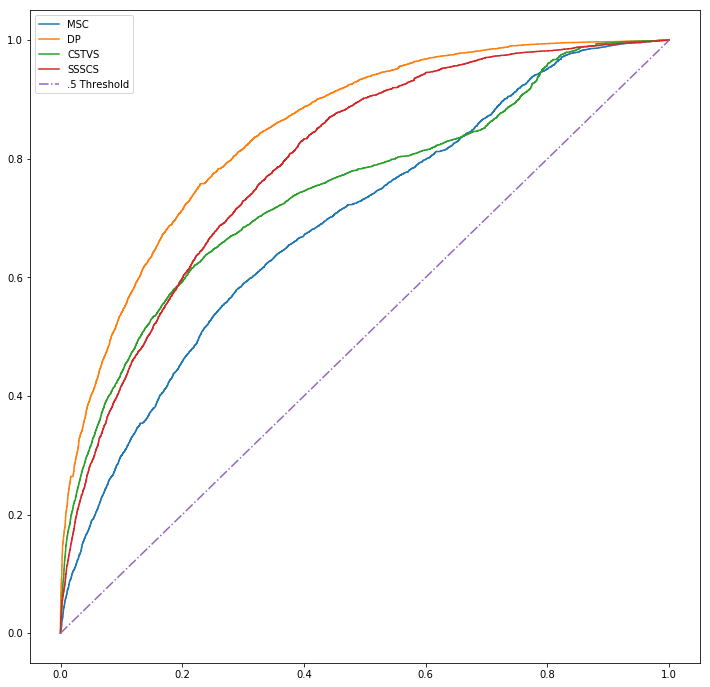

In [21]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in ['MSC','DP','CSTVS','SSSCS']:
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"{i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/poster_roc_curve.pdf',bbox_inches='tight')

In [22]:
csv_cols = ['tweet_id','irma_rel','MM_score_window_DP']

In [26]:
tweet_encoded[csv_cols].to_csv('./poster_text.csv')

In [25]:
%pwd

'/Users/brown/Documents/TwitterDisaster'